# Draw with CLIPDraw
### Omer Elgrably and Oded Drory

# Initial Setup

In [ ]:
# Define if you want to work with your drive
WORKING_WITH_DRIVE = False
# If you mount your drive define your relative path
DRIVE_PATH = '/content/drive/MyDrive/אוניברסיטה/תואר שני/בינתחומי/NLP/final_project'

In [ ]:
import subprocess
import os
import sys
from google.colab import drive

# pip install
packages = ['svgwrite','svgpathtools','cssutils','numba','torch-tools','visdom',
            'ftfy regex tqdm','git+https://github.com/openai/CLIP.git --no-deps']
for package in packages:
  os.system(f'pip install {package}')

# Set relative path
if WORKING_WITH_DRIVE:
  drive.mount('/content/drive')
  RELATIVE_PATH = DRIVE_PATH
else:
  RELATIVE_PATH = '/content/draw-clipdraw'

%cd {RELATIVE_PATH}
# Clone diffvg project
if os.path.isdir(f'{RELATIVE_PATH}/diffvg'):
  print(f'All good! You already have diffvg module on your directory')
else:
  os.system(f'git clone https://github.com/omerel/draw-clipdraw.git')

[Errno 2] No such file or directory: '/content/draw-clipdraw'
/content


In [ ]:
import os
%cd {RELATIVE_PATH}/diffvg
# Cmake for diffvg project
data = []
with open(f"{RELATIVE_PATH}/diffvg/CMakeLists.txt", "r+") as inFile:
    for line in inFile:
        if "find_package(TensorFlow)" in line:
            pass
        else:
            data.append(line)
    inFile.seek(0)
    for d in data:
        inFile.write(d)
    inFile.truncate()

returned_value = os.system(f'python setup.py install')
if returned_value == 0:
  print('Setup sucseess')
else:
  print('Setup failed')

/content/draw-clipdraw/diffvg
Setup sucseess


# !!!! Please restart runtime before continue !!!!

In [ ]:
# Setup again the working path
from google.colab import drive
# Define if you want to work with your drive
WORKING_WITH_DRIVE = False
# If you mount your drive define your relative path
DRIVE_PATH = '/content/drive/MyDrive/אוניברסיטה/תואר שני/בינתחומי/NLP/final_project'
# DRIVE_PATH = '/content/drive/MyDrive/NLP/final_project'
# Set relative path
if WORKING_WITH_DRIVE:
  drive.mount('/content/drive')
  RELATIVE_PATH = DRIVE_PATH
else:
  RELATIVE_PATH = '/content/draw-clipdraw'

# Custom modules imports

In [ ]:
%cd {RELATIVE_PATH}
import sys
sys.path.append(f'{RELATIVE_PATH}/diffvg')
import utils # image manipulations 
import image_render # image raster to vector
import sketcher # draw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import time
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

/content/draw-clipdraw
Torch version: 1.12.0+cu113


# Load pre-trained CLIP model and calculate features for result evaluation

In [ ]:
import os
import clip
import torch
import torch.nn.functional as F
import torchvision
import subprocess
from torchvision import transforms
from torchvision.datasets import CIFAR100
import clip_nouns


# Setup cuda version
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

# Load the model
device = torch.device('cuda')
model, preprocess = clip.load('ViT-B/32', device, jit=False)

nouns=clip_nouns.get_nouns()
nouns = nouns.split(" ")
noun_prompts = ["a drawing of a " + x for x in nouns]

# Calculate features
with torch.no_grad():
    nouns_features = model.encode_text(torch.cat([clip.tokenize(noun_prompts).to(device)]))
print(nouns_features.shape, nouns_features.dtype)

CUDA version: 11.1


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 262MiB/s]


torch.Size([2343, 512]) torch.float16


# Parameters:

In [ ]:
# The draw title
prompt = "Summer in paris"

result_folder=time.strftime("%d-%m_%H-%M-%S") #save results

# Learing configuration
random_init = False # use random init (original work) or init draw (my work)
use_blob = True #draw and learn strokes or blobs
use_negative = True # Use negative prompts (built in feature of the original project)
use_normalized_clip = True #built in feature of the original project
if random_init:
  use_blob = False

# Image render configuration
img_init_path = f"{RELATIVE_PATH}/{result_folder}_drawing.jpg"
num_iter_render = 150
use_lpips_loss = False # Learned Perceptual Image Patch Similarity (LPIPS) metric

# ARGUMENTS varibles
args = lambda: None
args.num_paths = 500 #num of stroks/blobs
args.num_iter = 500
args.max_width = 100

In [ ]:
# Save drawing configuration
import json

general = {"prompt":prompt,
           "result_folder":result_folder}
learning_conf = {"random_init":random_init,
                 "use_negative":use_negative,
                 "use_normalized_clip":use_normalized_clip,
                 "use_blob":use_blob}
img_render_conf = {"img_init_path":img_init_path,
                   "num_iter_render":num_iter_render,
                   "use_lpips_loss":use_lpips_loss}
arguments_conf = {"num_paths":args.num_paths,
                  "num_iter":args.num_iter,
                  "max_width":args.max_width
                  }
conf_json = {"general":general,
             "learning_conf":learning_conf,
             "img_render_conf":img_render_conf,
             "arguments_conf":arguments_conf}

jsonString = json.dumps(conf_json)
jsonFile = open(f"{RELATIVE_PATH}/{result_folder}_conf.json", "w")
jsonFile.write(jsonString)
jsonFile.close()
print(json.dumps(json.loads(jsonString), indent=4, sort_keys=True))

{
    "arguments_conf": {
        "max_width": 100,
        "num_iter": 500,
        "num_paths": 500
    },
    "general": {
        "prompt": "Summer in paris",
        "result_folder": "30-07_19-50-46"
    },
    "img_render_conf": {
        "img_init_path": "/content/draw-clipdraw/30-07_19-50-46_drawing.jpg",
        "num_iter_render": 150,
        "use_lpips_loss": false
    },
    "learning_conf": {
        "random_init": false,
        "use_blob": true,
        "use_negative": true,
        "use_normalized_clip": true
    }
}


# Draw an image that addresse your prompt:

In [ ]:
# Draw your propt
%cd {RELATIVE_PATH}
sketcher.draw(result_folder)

/content/draw-clipdraw


12035

# Train

  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "

  warnings.warn(msg)



/content/draw-clipdraw/diffvg/apps
Scene construction, time: 0.00201 s
Forward pass, time: 0.01502 s
iteration: 0
Scene construction, time: 0.00147 s
Forward pass, time: 0.01504 s
render loss: 0.07498455792665482
Backward pass, time: 0.04615 s
iteration: 1
Scene construction, time: 0.00140 s
Forward pass, time: 0.01460 s
render loss: 0.05464525148272514
Backward pass, time: 0.04357 s
iteration: 2
Scene construction, time: 0.00147 s
Forward pass, time: 0.01526 s
render loss: 0.04548896104097366
Backward pass, time: 0.04398 s
iteration: 3
Scene construction, time: 0.00149 s
Forward pass, time: 0.01503 s
render loss: 0.041411109268665314
Backward pass, time: 0.04442 s
iteration: 4
Scene construction, time: 0.00146 s
Forward pass, time: 0.01523 s
render loss: 0.038082510232925415
Backward pass, time: 0.04524 s
iteration: 5
Scene construction, time: 0.00153 s
Forward pass, time: 0.01558 s
render loss: 0.035153113305568695
Backward pass, time: 0.04569 s
iteration: 6
Scene construction, time:

  skimage.io.imsave(filename, (img * 255).astype(np.uint8))



Scene construction, time: 0.00140 s
Forward pass, time: 0.00222 s
Scene construction, time: 0.00193 s
Forward pass, time: 0.03113 s
Backward pass, time: 0.08829 s


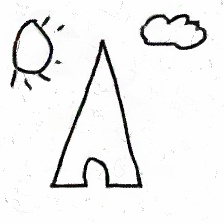

render loss: -0.236328125
iteration: 0

Top predictions:

           cloud: 2.65%
         weather: 2.34%
     meteorology: 2.23%
       trapezoid: 1.79%
            kite: 1.56%
Scene construction, time: 0.00153 s
Forward pass, time: 0.02251 s
Backward pass, time: 0.06458 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.01682 s
Backward pass, time: 0.04794 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.01879 s
Backward pass, time: 0.04873 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.01688 s
Backward pass, time: 0.05141 s
Scene construction, time: 0.00163 s
Forward pass, time: 0.01739 s
Backward pass, time: 0.04741 s
Scene construction, time: 0.00198 s
Forward pass, time: 0.01868 s
Backward pass, time: 0.04977 s
Scene construction, time: 0.00127 s
Forward pass, time: 0.01726 s
Backward pass, time: 0.05036 s
Scene construction, time: 0.00139 s
Forward pass, time: 0.01762 s
Backward pass, time: 0.04964 s
Scene construction, time: 0.00139 s
Forward pa

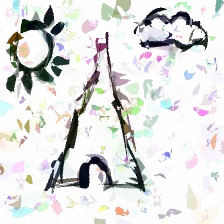

render loss: -0.615234375
iteration: 10

Top predictions:

      tablecloth: 4.77%
          france: 3.60%
        umbrella: 3.13%
           tower: 2.80%
        raincoat: 2.40%
Scene construction, time: 0.00154 s
Forward pass, time: 0.01813 s
Backward pass, time: 0.05162 s
Scene construction, time: 0.00159 s
Forward pass, time: 0.01877 s
Backward pass, time: 0.05312 s
Scene construction, time: 0.00137 s
Forward pass, time: 0.01775 s
Backward pass, time: 0.05108 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.01784 s
Backward pass, time: 0.05004 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.01706 s
Backward pass, time: 0.04835 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.01765 s
Backward pass, time: 0.04942 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.01783 s
Backward pass, time: 0.05181 s
Scene construction, time: 0.00158 s
Forward pass, time: 0.01767 s
Backward pass, time: 0.05019 s
Scene construction, time: 0.00142 s
Forward p

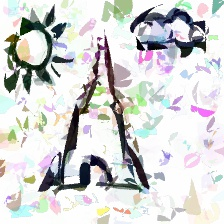

render loss: -0.6474609375
iteration: 20

Top predictions:

          france: 4.30%
       windchime: 2.53%
           tower: 2.16%
        umbrella: 1.82%
          french: 1.61%
Scene construction, time: 0.00151 s
Forward pass, time: 0.01792 s
Backward pass, time: 0.05164 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.01865 s
Backward pass, time: 0.05205 s
Scene construction, time: 0.00137 s
Forward pass, time: 0.01885 s
Backward pass, time: 0.05466 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.01927 s
Backward pass, time: 0.05253 s
Scene construction, time: 0.00161 s
Forward pass, time: 0.01960 s
Backward pass, time: 0.05373 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.01917 s
Backward pass, time: 0.05392 s
Scene construction, time: 0.00136 s
Forward pass, time: 0.01962 s
Backward pass, time: 0.05757 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.02006 s
Backward pass, time: 0.05561 s
Scene construction, time: 0.00141 s
Forward 

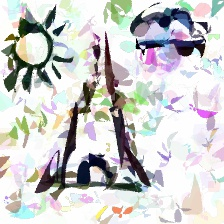

render loss: -0.67578125
iteration: 30

Top predictions:

          france: 4.50%
          summer: 3.97%
          french: 3.39%
        vacation: 1.73%
         picture: 1.02%
Scene construction, time: 0.00152 s
Forward pass, time: 0.02162 s
Backward pass, time: 0.05770 s
Scene construction, time: 0.00138 s
Forward pass, time: 0.02060 s
Backward pass, time: 0.05748 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.02085 s
Backward pass, time: 0.06005 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.02073 s
Backward pass, time: 0.05802 s
Scene construction, time: 0.00133 s
Forward pass, time: 0.02152 s
Backward pass, time: 0.06062 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.02128 s
Backward pass, time: 0.06004 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.02242 s
Backward pass, time: 0.06059 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.02164 s
Backward pass, time: 0.06123 s
Scene construction, time: 0.00139 s
Forward pa

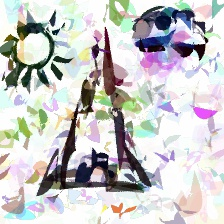

render loss: -0.7412109375
iteration: 40

Top predictions:

          france: 6.75%
          summer: 6.64%
          french: 3.34%
        vacation: 3.14%
           tower: 1.31%
Scene construction, time: 0.00149 s
Forward pass, time: 0.02374 s
Backward pass, time: 0.06228 s
Scene construction, time: 0.00138 s
Forward pass, time: 0.02275 s
Backward pass, time: 0.06307 s
Scene construction, time: 0.00134 s
Forward pass, time: 0.02331 s
Backward pass, time: 0.06397 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.02374 s
Backward pass, time: 0.06536 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.02418 s
Backward pass, time: 0.06731 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.02395 s
Backward pass, time: 0.06614 s
Scene construction, time: 0.00161 s
Forward pass, time: 0.02886 s
Backward pass, time: 0.06819 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.02468 s
Backward pass, time: 0.06801 s
Scene construction, time: 0.00155 s
Forward 

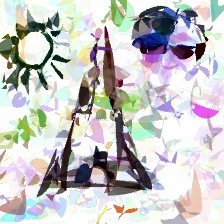

render loss: -0.79736328125
iteration: 50

Top predictions:

          summer: 11.89%
          france: 4.96%
          french: 3.46%
        vacation: 3.30%
           frame: 1.23%
Scene construction, time: 0.00148 s
Forward pass, time: 0.02590 s
Backward pass, time: 0.06827 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.02476 s
Backward pass, time: 0.07017 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.02574 s
Backward pass, time: 0.06911 s
Scene construction, time: 0.00162 s
Forward pass, time: 0.02520 s
Backward pass, time: 0.07119 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.02566 s
Backward pass, time: 0.07256 s
Scene construction, time: 0.00139 s
Forward pass, time: 0.02723 s
Backward pass, time: 0.07315 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.02642 s
Backward pass, time: 0.07327 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.02670 s
Backward pass, time: 0.07311 s
Scene construction, time: 0.00147 s
Forwar

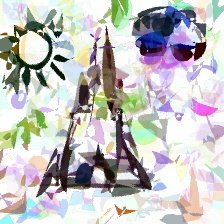

render loss: -0.859375
iteration: 60

Top predictions:

          summer: 22.68%
          france: 10.06%
        vacation: 7.96%
          french: 4.53%
        sunshine: 1.64%
Scene construction, time: 0.00153 s
Forward pass, time: 0.02759 s
Backward pass, time: 0.07195 s
Scene construction, time: 0.00153 s
Forward pass, time: 0.02679 s
Backward pass, time: 0.07525 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.02699 s
Backward pass, time: 0.07484 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.02731 s
Backward pass, time: 0.07723 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.02913 s
Backward pass, time: 0.08176 s
Scene construction, time: 0.00159 s
Forward pass, time: 0.02837 s
Backward pass, time: 0.07859 s
Scene construction, time: 0.00139 s
Forward pass, time: 0.02940 s
Backward pass, time: 0.07917 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.02976 s
Backward pass, time: 0.07762 s
Scene construction, time: 0.00139 s
Forward pa

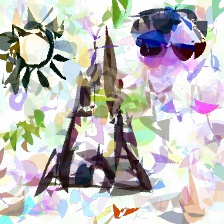

render loss: -0.85986328125
iteration: 70

Top predictions:

          summer: 24.11%
          france: 13.11%
        vacation: 4.90%
          french: 4.60%
         holiday: 2.50%
Scene construction, time: 0.00153 s
Forward pass, time: 0.02935 s
Backward pass, time: 0.08015 s
Scene construction, time: 0.00139 s
Forward pass, time: 0.02968 s
Backward pass, time: 0.08089 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.02943 s
Backward pass, time: 0.08280 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.03077 s
Backward pass, time: 0.08045 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.02973 s
Backward pass, time: 0.08430 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.03034 s
Backward pass, time: 0.08487 s
Scene construction, time: 0.00150 s
Forward pass, time: 0.03134 s
Backward pass, time: 0.08534 s
Scene construction, time: 0.00157 s
Forward pass, time: 0.03031 s
Backward pass, time: 0.08388 s
Scene construction, time: 0.00158 s
Forwa

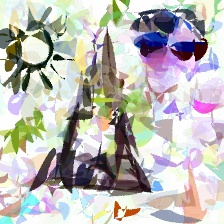

render loss: -0.87890625
iteration: 80

Top predictions:

          summer: 21.61%
          france: 7.70%
        vacation: 7.12%
         holiday: 2.24%
          french: 2.11%
Scene construction, time: 0.00133 s
Forward pass, time: 0.03200 s
Backward pass, time: 0.08793 s
Scene construction, time: 0.00203 s
Forward pass, time: 0.03203 s
Backward pass, time: 0.08551 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.03152 s
Backward pass, time: 0.08916 s
Scene construction, time: 0.00133 s
Forward pass, time: 0.03154 s
Backward pass, time: 0.08737 s
Scene construction, time: 0.00136 s
Forward pass, time: 0.03158 s
Backward pass, time: 0.08888 s
Scene construction, time: 0.00139 s
Forward pass, time: 0.03198 s
Backward pass, time: 0.08924 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.03207 s
Backward pass, time: 0.08956 s
Scene construction, time: 0.00143 s
Forward pass, time: 0.03279 s
Backward pass, time: 0.08961 s
Scene construction, time: 0.00138 s
Forward p

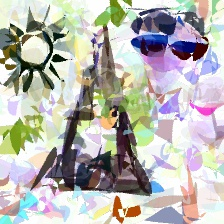

render loss: -0.86376953125
iteration: 90

Top predictions:

          summer: 11.93%
          france: 9.59%
           frame: 3.88%
       billboard: 1.95%
          screen: 1.69%
Scene construction, time: 0.00208 s
Forward pass, time: 0.03368 s
Backward pass, time: 0.09206 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.03357 s
Backward pass, time: 0.09256 s
Scene construction, time: 0.00134 s
Forward pass, time: 0.03478 s
Backward pass, time: 0.09360 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.03416 s
Backward pass, time: 0.09271 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.03421 s
Backward pass, time: 0.09360 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.03434 s
Backward pass, time: 0.09373 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.03463 s
Backward pass, time: 0.09527 s
Scene construction, time: 0.00153 s
Forward pass, time: 0.03458 s
Backward pass, time: 0.09509 s
Scene construction, time: 0.00148 s
Forwar

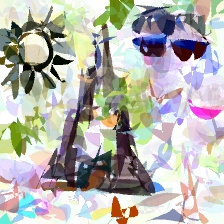

render loss: -0.94921875
iteration: 100

Top predictions:

          summer: 35.16%
        vacation: 13.13%
          france: 8.61%
         holiday: 3.22%
          french: 3.17%
Scene construction, time: 0.00150 s
Forward pass, time: 0.03624 s
Backward pass, time: 0.09776 s
Scene construction, time: 0.00157 s
Forward pass, time: 0.03688 s
Backward pass, time: 0.09678 s
Scene construction, time: 0.00133 s
Forward pass, time: 0.03524 s
Backward pass, time: 0.10029 s
Scene construction, time: 0.00153 s
Forward pass, time: 0.03570 s
Backward pass, time: 0.09775 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.03596 s
Backward pass, time: 0.09920 s
Scene construction, time: 0.00156 s
Forward pass, time: 0.03775 s
Backward pass, time: 0.09917 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.03623 s
Backward pass, time: 0.10081 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.03716 s
Backward pass, time: 0.10104 s
Scene construction, time: 0.00138 s
Forward

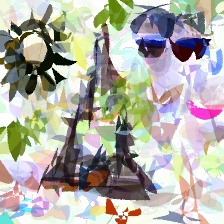

render loss: -0.80419921875
iteration: 110

Top predictions:

          summer: 21.68%
          france: 6.82%
        vacation: 5.31%
          french: 3.07%
        thailand: 1.55%
Scene construction, time: 0.00147 s
Forward pass, time: 0.03826 s
Backward pass, time: 0.10279 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.03848 s
Backward pass, time: 0.10332 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.03841 s
Backward pass, time: 0.10424 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.03853 s
Backward pass, time: 0.10726 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.03935 s
Backward pass, time: 0.10746 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.04073 s
Backward pass, time: 0.10667 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.03979 s
Backward pass, time: 0.10758 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.04067 s
Backward pass, time: 0.11090 s
Scene construction, time: 0.00137 s
Forwa

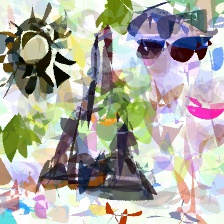

render loss: -0.89404296875
iteration: 120

Top predictions:

          summer: 20.63%
          france: 13.53%
        vacation: 5.55%
          french: 3.42%
      mini-skirt: 1.15%
Scene construction, time: 0.00136 s
Forward pass, time: 0.04148 s
Backward pass, time: 0.10964 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.04209 s
Backward pass, time: 0.11244 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.04209 s
Backward pass, time: 0.11391 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.04115 s
Backward pass, time: 0.11422 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.04438 s
Backward pass, time: 0.11558 s
Scene construction, time: 0.00154 s
Forward pass, time: 0.04358 s
Backward pass, time: 0.11451 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.04303 s
Backward pass, time: 0.11472 s
Scene construction, time: 0.00215 s
Forward pass, time: 0.04211 s
Backward pass, time: 0.11693 s
Scene construction, time: 0.00159 s
Forw

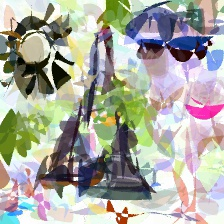

render loss: -0.97314453125
iteration: 130

Top predictions:

          france: 15.50%
          summer: 14.33%
          french: 5.53%
        vacation: 4.65%
         holiday: 2.03%
Scene construction, time: 0.00219 s
Forward pass, time: 0.04354 s
Backward pass, time: 0.11996 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.04680 s
Backward pass, time: 0.11720 s
Scene construction, time: 0.00139 s
Forward pass, time: 0.04474 s
Backward pass, time: 0.11836 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.04468 s
Backward pass, time: 0.11888 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.04546 s
Backward pass, time: 0.12062 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.04564 s
Backward pass, time: 0.11953 s
Scene construction, time: 0.00136 s
Forward pass, time: 0.04465 s
Backward pass, time: 0.11842 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.04462 s
Backward pass, time: 0.11955 s
Scene construction, time: 0.00152 s
Forw

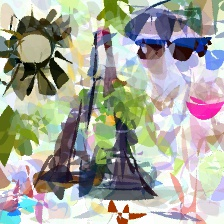

render loss: -0.9453125
iteration: 140

Top predictions:

          summer: 13.85%
          france: 13.01%
        vacation: 3.91%
          french: 2.33%
         jogging: 1.44%
Scene construction, time: 0.00213 s
Forward pass, time: 0.04541 s
Backward pass, time: 0.12305 s
Scene construction, time: 0.00139 s
Forward pass, time: 0.04718 s
Backward pass, time: 0.12424 s
Scene construction, time: 0.00135 s
Forward pass, time: 0.04670 s
Backward pass, time: 0.12570 s
Scene construction, time: 0.00150 s
Forward pass, time: 0.04737 s
Backward pass, time: 0.12758 s
Scene construction, time: 0.00207 s
Forward pass, time: 0.04699 s
Backward pass, time: 0.12786 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.04861 s
Backward pass, time: 0.12766 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.04702 s
Backward pass, time: 0.12932 s
Scene construction, time: 0.00137 s
Forward pass, time: 0.04754 s
Backward pass, time: 0.12664 s
Scene construction, time: 0.00146 s
Forward 

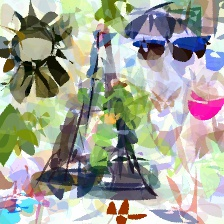

render loss: -1.0048828125
iteration: 150

Top predictions:

          summer: 47.97%
          france: 3.02%
        vacation: 2.75%
      mini-skirt: 1.54%
       windchime: 1.13%
Scene construction, time: 0.00151 s
Forward pass, time: 0.04741 s
Backward pass, time: 0.12813 s
Scene construction, time: 0.00150 s
Forward pass, time: 0.05085 s
Backward pass, time: 0.12990 s
Scene construction, time: 0.00150 s
Forward pass, time: 0.04929 s
Backward pass, time: 0.13063 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.04918 s
Backward pass, time: 0.13052 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.04988 s
Backward pass, time: 0.13354 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.05058 s
Backward pass, time: 0.13209 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.05011 s
Backward pass, time: 0.14112 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.05055 s
Backward pass, time: 0.13419 s
Scene construction, time: 0.00142 s
Forwar

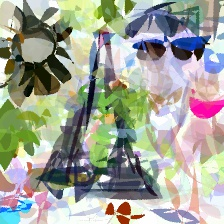

render loss: -0.990234375
iteration: 160

Top predictions:

          summer: 31.27%
          france: 16.75%
          french: 5.97%
        vacation: 1.46%
        umbrella: 1.25%
Scene construction, time: 0.00143 s
Forward pass, time: 0.05057 s
Backward pass, time: 0.13537 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.05236 s
Backward pass, time: 0.13574 s
Scene construction, time: 0.00138 s
Forward pass, time: 0.05172 s
Backward pass, time: 0.13553 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.05355 s
Backward pass, time: 0.13579 s
Scene construction, time: 0.00138 s
Forward pass, time: 0.05868 s
Backward pass, time: 0.13815 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.05237 s
Backward pass, time: 0.13863 s
Scene construction, time: 0.00155 s
Forward pass, time: 0.05360 s
Backward pass, time: 0.13690 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.05198 s
Backward pass, time: 0.13817 s
Scene construction, time: 0.00141 s
Forwar

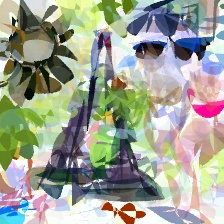

render loss: -0.9892578125
iteration: 170

Top predictions:

          summer: 63.43%
          france: 8.19%
        vacation: 6.90%
          french: 1.20%
         holiday: 1.04%
Scene construction, time: 0.00164 s
Forward pass, time: 0.05109 s
Backward pass, time: 0.13927 s
Scene construction, time: 0.00139 s
Forward pass, time: 0.05389 s
Backward pass, time: 0.13885 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.05312 s
Backward pass, time: 0.13815 s
Scene construction, time: 0.00150 s
Forward pass, time: 0.05417 s
Backward pass, time: 0.13981 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.05425 s
Backward pass, time: 0.14387 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.05390 s
Backward pass, time: 0.14077 s
Scene construction, time: 0.00150 s
Forward pass, time: 0.05247 s
Backward pass, time: 0.13945 s
Scene construction, time: 0.00155 s
Forward pass, time: 0.05391 s
Backward pass, time: 0.13965 s
Scene construction, time: 0.00155 s
Forwar

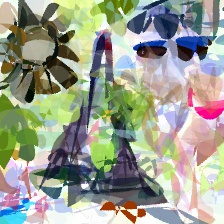

render loss: -0.94970703125
iteration: 180

Top predictions:

          summer: 28.49%
          france: 9.84%
        vacation: 4.87%
          french: 2.87%
      mini-skirt: 2.13%
Scene construction, time: 0.00145 s
Forward pass, time: 0.05332 s
Backward pass, time: 0.14329 s
Scene construction, time: 0.00154 s
Forward pass, time: 0.05393 s
Backward pass, time: 0.14129 s
Scene construction, time: 0.00139 s
Forward pass, time: 0.05404 s
Backward pass, time: 0.14292 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.05474 s
Backward pass, time: 0.14321 s
Scene construction, time: 0.00150 s
Forward pass, time: 0.05488 s
Backward pass, time: 0.14538 s
Scene construction, time: 0.00138 s
Forward pass, time: 0.05741 s
Backward pass, time: 0.14749 s
Scene construction, time: 0.00180 s
Forward pass, time: 0.05447 s
Backward pass, time: 0.14712 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.05595 s
Backward pass, time: 0.14712 s
Scene construction, time: 0.00150 s
Forwa

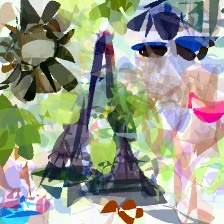

render loss: -0.96044921875
iteration: 190

Top predictions:

          summer: 35.47%
        vacation: 15.99%
          france: 14.11%
          french: 2.45%
           beach: 2.13%
Scene construction, time: 0.00152 s
Forward pass, time: 0.05614 s
Backward pass, time: 0.15272 s
Scene construction, time: 0.00137 s
Forward pass, time: 0.05772 s
Backward pass, time: 0.14967 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.05540 s
Backward pass, time: 0.15095 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.05611 s
Backward pass, time: 0.14767 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.05532 s
Backward pass, time: 0.15211 s
Scene construction, time: 0.00138 s
Forward pass, time: 0.05711 s
Backward pass, time: 0.15309 s
Scene construction, time: 0.00150 s
Forward pass, time: 0.05656 s
Backward pass, time: 0.15003 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.05618 s
Backward pass, time: 0.15248 s
Scene construction, time: 0.00137 s
For

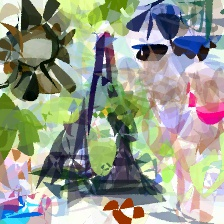

render loss: -1.03125
iteration: 200

Top predictions:

          summer: 59.18%
          france: 8.53%
        vacation: 6.85%
          french: 2.33%
         holiday: 1.71%
Scene construction, time: 0.00141 s
Forward pass, time: 0.05699 s
Backward pass, time: 0.15594 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.05823 s
Backward pass, time: 0.15721 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.05917 s
Backward pass, time: 0.15746 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.05871 s
Backward pass, time: 0.15838 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.05933 s
Backward pass, time: 0.15801 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.05906 s
Backward pass, time: 0.15814 s
Scene construction, time: 0.00153 s
Forward pass, time: 0.06066 s
Backward pass, time: 0.16151 s
Scene construction, time: 0.00135 s
Forward pass, time: 0.05883 s
Backward pass, time: 0.15900 s
Scene construction, time: 0.00143 s
Forward pas

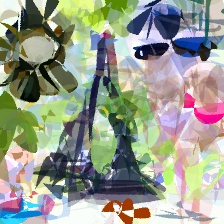

render loss: -1.060546875
iteration: 210

Top predictions:

          summer: 60.40%
          france: 7.56%
        vacation: 3.80%
       windchime: 3.25%
      mini-skirt: 1.38%
Scene construction, time: 0.00225 s
Forward pass, time: 0.05920 s
Backward pass, time: 0.16169 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.06313 s
Backward pass, time: 0.16189 s
Scene construction, time: 0.00134 s
Forward pass, time: 0.06074 s
Backward pass, time: 0.16492 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.06050 s
Backward pass, time: 0.16187 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.06097 s
Backward pass, time: 0.16293 s
Scene construction, time: 0.00162 s
Forward pass, time: 0.06376 s
Backward pass, time: 0.16501 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.06181 s
Backward pass, time: 0.16374 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.06392 s
Backward pass, time: 0.16738 s
Scene construction, time: 0.00142 s
Forward

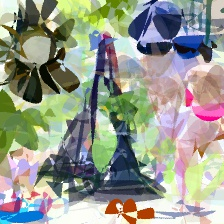

render loss: -1.046875
iteration: 220

Top predictions:

          france: 28.17%
          summer: 21.25%
          french: 9.44%
        vacation: 1.59%
            park: 1.03%
Scene construction, time: 0.00262 s
Forward pass, time: 0.06422 s
Backward pass, time: 0.16890 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.06310 s
Backward pass, time: 0.16975 s
Scene construction, time: 0.00133 s
Forward pass, time: 0.06344 s
Backward pass, time: 0.17041 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.06576 s
Backward pass, time: 0.17297 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.06423 s
Backward pass, time: 0.16672 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.06370 s
Backward pass, time: 0.16911 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.06349 s
Backward pass, time: 0.16888 s
Scene construction, time: 0.00150 s
Forward pass, time: 0.06423 s
Backward pass, time: 0.17048 s
Scene construction, time: 0.00149 s
Forward p

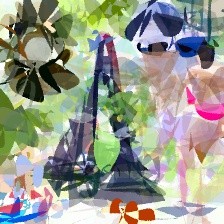

render loss: -1.0458984375
iteration: 230

Top predictions:

          summer: 48.19%
          france: 9.64%
        vacation: 6.73%
          french: 2.59%
         holiday: 1.30%
Scene construction, time: 0.00207 s
Forward pass, time: 0.06236 s
Backward pass, time: 0.17059 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.06528 s
Backward pass, time: 0.17456 s
Scene construction, time: 0.00139 s
Forward pass, time: 0.06505 s
Backward pass, time: 0.17410 s
Scene construction, time: 0.00143 s
Forward pass, time: 0.06435 s
Backward pass, time: 0.17515 s
Scene construction, time: 0.00155 s
Forward pass, time: 0.06781 s
Backward pass, time: 0.17862 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.06563 s
Backward pass, time: 0.17573 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.06566 s
Backward pass, time: 0.17413 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.06662 s
Backward pass, time: 0.17833 s
Scene construction, time: 0.00137 s
Forwar

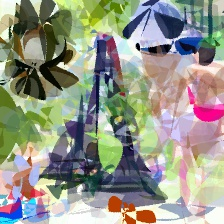

render loss: -1.01953125
iteration: 240

Top predictions:

          summer: 64.75%
          france: 3.03%
        vacation: 2.18%
            park: 1.00%
          french: 0.84%
Scene construction, time: 0.00144 s
Forward pass, time: 0.06384 s
Backward pass, time: 0.17396 s
Scene construction, time: 0.00158 s
Forward pass, time: 0.06773 s
Backward pass, time: 0.17537 s
Scene construction, time: 0.00136 s
Forward pass, time: 0.06542 s
Backward pass, time: 0.17507 s
Scene construction, time: 0.00155 s
Forward pass, time: 0.06627 s
Backward pass, time: 0.17882 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.06780 s
Backward pass, time: 0.17930 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.06661 s
Backward pass, time: 0.18146 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.07529 s
Backward pass, time: 0.18037 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.06766 s
Backward pass, time: 0.18192 s
Scene construction, time: 0.00142 s
Forward 

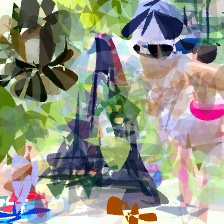

render loss: -0.9970703125
iteration: 250

Top predictions:

          summer: 36.65%
        vacation: 15.04%
          france: 3.74%
            park: 3.05%
         holiday: 2.31%
Scene construction, time: 0.00213 s
Forward pass, time: 0.06567 s
Backward pass, time: 0.18406 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.06937 s
Backward pass, time: 0.18307 s
Scene construction, time: 0.00138 s
Forward pass, time: 0.06758 s
Backward pass, time: 0.18240 s
Scene construction, time: 0.00168 s
Forward pass, time: 0.06819 s
Backward pass, time: 0.18232 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.06892 s
Backward pass, time: 0.18637 s
Scene construction, time: 0.00143 s
Forward pass, time: 0.06930 s
Backward pass, time: 0.19578 s
Scene construction, time: 0.00182 s
Forward pass, time: 0.06888 s
Backward pass, time: 0.18533 s
Scene construction, time: 0.00138 s
Forward pass, time: 0.06880 s
Backward pass, time: 0.18657 s
Scene construction, time: 0.00142 s
Forwa

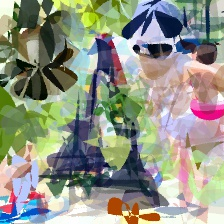

render loss: -1.0361328125
iteration: 260

Top predictions:

          summer: 34.38%
          france: 12.65%
        vacation: 5.61%
          french: 5.03%
        raincoat: 2.45%
Scene construction, time: 0.00143 s
Forward pass, time: 0.06868 s
Backward pass, time: 0.18811 s
Scene construction, time: 0.00156 s
Forward pass, time: 0.07018 s
Backward pass, time: 0.18724 s
Scene construction, time: 0.00143 s
Forward pass, time: 0.07103 s
Backward pass, time: 0.18743 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.07011 s
Backward pass, time: 0.18719 s
Scene construction, time: 0.00153 s
Forward pass, time: 0.07011 s
Backward pass, time: 0.18814 s
Scene construction, time: 0.00155 s
Forward pass, time: 0.07061 s
Backward pass, time: 0.18820 s
Scene construction, time: 0.00153 s
Forward pass, time: 0.07052 s
Backward pass, time: 0.18910 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.07040 s
Backward pass, time: 0.18777 s
Scene construction, time: 0.00131 s
Forwa

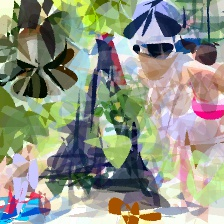

render loss: -1.1015625
iteration: 270

Top predictions:

          summer: 22.22%
          france: 20.23%
          french: 8.04%
       windchime: 4.80%
        umbrella: 4.31%
Scene construction, time: 0.00219 s
Forward pass, time: 0.06799 s
Backward pass, time: 0.18506 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.06928 s
Backward pass, time: 0.18571 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.06992 s
Backward pass, time: 0.18647 s
Scene construction, time: 0.00138 s
Forward pass, time: 0.07085 s
Backward pass, time: 0.19391 s
Scene construction, time: 0.00158 s
Forward pass, time: 0.07068 s
Backward pass, time: 0.18804 s
Scene construction, time: 0.00158 s
Forward pass, time: 0.06980 s
Backward pass, time: 0.18967 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.06996 s
Backward pass, time: 0.18776 s
Scene construction, time: 0.00159 s
Forward pass, time: 0.06954 s
Backward pass, time: 0.19129 s
Scene construction, time: 0.00147 s
Forward 

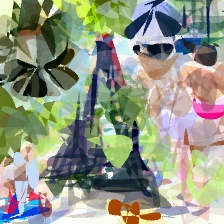

render loss: -1.1435546875
iteration: 280

Top predictions:

          summer: 58.94%
        vacation: 10.24%
          france: 9.93%
         holiday: 1.81%
          french: 1.73%
Scene construction, time: 0.00154 s
Forward pass, time: 0.06939 s
Backward pass, time: 0.18976 s
Scene construction, time: 0.00161 s
Forward pass, time: 0.07102 s
Backward pass, time: 0.19142 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.07239 s
Backward pass, time: 0.18847 s
Scene construction, time: 0.00158 s
Forward pass, time: 0.07114 s
Backward pass, time: 0.19086 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.07087 s
Backward pass, time: 0.19246 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.07080 s
Backward pass, time: 0.19172 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.07039 s
Backward pass, time: 0.19129 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.07030 s
Backward pass, time: 0.19078 s
Scene construction, time: 0.00142 s
Forwa

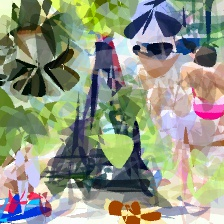

render loss: -1.1513671875
iteration: 290

Top predictions:

          summer: 41.21%
          france: 27.03%
        vacation: 7.05%
          french: 6.73%
            july: 1.90%
Scene construction, time: 0.00163 s
Forward pass, time: 0.06908 s
Backward pass, time: 0.19002 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.07058 s
Backward pass, time: 0.19148 s
Scene construction, time: 0.00135 s
Forward pass, time: 0.07118 s
Backward pass, time: 0.19320 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.07120 s
Backward pass, time: 0.19210 s
Scene construction, time: 0.00136 s
Forward pass, time: 0.07274 s
Backward pass, time: 0.18972 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.07261 s
Backward pass, time: 0.19071 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.07151 s
Backward pass, time: 0.18962 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.07149 s
Backward pass, time: 0.19421 s
Scene construction, time: 0.00144 s
Forwa

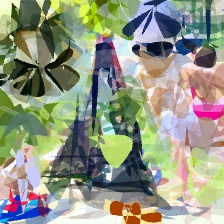

render loss: -1.1884765625
iteration: 300

Top predictions:

          summer: 65.92%
        vacation: 5.85%
          france: 5.41%
       afternoon: 1.37%
         holiday: 1.07%
Scene construction, time: 0.00214 s
Forward pass, time: 0.06949 s
Backward pass, time: 0.19084 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.07123 s
Backward pass, time: 0.19255 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.07162 s
Backward pass, time: 0.19163 s
Scene construction, time: 0.00172 s
Forward pass, time: 0.07127 s
Backward pass, time: 0.19214 s
Scene construction, time: 0.00135 s
Forward pass, time: 0.07222 s
Backward pass, time: 0.19481 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.07245 s
Backward pass, time: 0.19277 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.07227 s
Backward pass, time: 0.19784 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.07117 s
Backward pass, time: 0.18955 s
Scene construction, time: 0.00141 s
Forwar

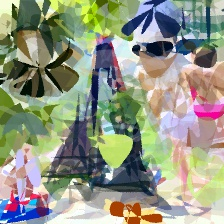

render loss: -1.1572265625
iteration: 310

Top predictions:

          summer: 91.85%
        vacation: 1.31%
            july: 1.23%
          france: 0.79%
          french: 0.40%
Scene construction, time: 0.00219 s
Forward pass, time: 0.07031 s
Backward pass, time: 0.19596 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.07056 s
Backward pass, time: 0.19219 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.07034 s
Backward pass, time: 0.18909 s
Scene construction, time: 0.00132 s
Forward pass, time: 0.06976 s
Backward pass, time: 0.18860 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.07142 s
Backward pass, time: 0.19177 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.06990 s
Backward pass, time: 0.18775 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.07035 s
Backward pass, time: 0.19183 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.07016 s
Backward pass, time: 0.19067 s
Scene construction, time: 0.00148 s
Forwar

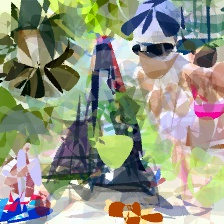

render loss: -1.1767578125
iteration: 320

Top predictions:

          summer: 79.93%
          france: 4.17%
        vacation: 2.23%
            july: 1.71%
          french: 1.19%
Scene construction, time: 0.00199 s
Forward pass, time: 0.06859 s
Backward pass, time: 0.19119 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.07024 s
Backward pass, time: 0.18977 s
Scene construction, time: 0.00143 s
Forward pass, time: 0.07297 s
Backward pass, time: 0.19623 s
Scene construction, time: 0.00156 s
Forward pass, time: 0.07007 s
Backward pass, time: 0.18869 s
Scene construction, time: 0.00166 s
Forward pass, time: 0.07054 s
Backward pass, time: 0.18808 s
Scene construction, time: 0.00143 s
Forward pass, time: 0.07030 s
Backward pass, time: 0.19017 s
Scene construction, time: 0.00157 s
Forward pass, time: 0.07027 s
Backward pass, time: 0.19112 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.06912 s
Backward pass, time: 0.18933 s
Scene construction, time: 0.00152 s
Forwar

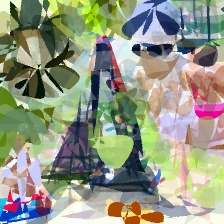

render loss: -1.1298828125
iteration: 330

Top predictions:

          summer: 79.74%
        vacation: 5.10%
          france: 2.73%
          french: 1.08%
            july: 0.96%
Scene construction, time: 0.00200 s
Forward pass, time: 0.06900 s
Backward pass, time: 0.18800 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.07082 s
Backward pass, time: 0.18773 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.07079 s
Backward pass, time: 0.19095 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.07050 s
Backward pass, time: 0.18944 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.07029 s
Backward pass, time: 0.18726 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.07016 s
Backward pass, time: 0.19026 s
Scene construction, time: 0.00138 s
Forward pass, time: 0.06998 s
Backward pass, time: 0.18802 s
Scene construction, time: 0.00154 s
Forward pass, time: 0.07133 s
Backward pass, time: 0.19084 s
Scene construction, time: 0.00149 s
Forwar

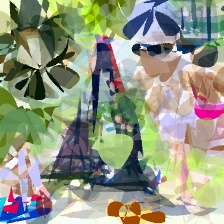

render loss: -1.212890625
iteration: 340

Top predictions:

          summer: 75.20%
          france: 5.98%
        vacation: 5.71%
         holiday: 1.42%
            july: 1.36%
Scene construction, time: 0.00215 s
Forward pass, time: 0.07160 s
Backward pass, time: 0.19383 s
Scene construction, time: 0.00164 s
Forward pass, time: 0.07201 s
Backward pass, time: 0.19248 s
Scene construction, time: 0.00137 s
Forward pass, time: 0.07304 s
Backward pass, time: 0.19349 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.07213 s
Backward pass, time: 0.19361 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.07295 s
Backward pass, time: 0.19399 s
Scene construction, time: 0.00137 s
Forward pass, time: 0.07518 s
Backward pass, time: 0.19195 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.07295 s
Backward pass, time: 0.19743 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.07273 s
Backward pass, time: 0.19458 s
Scene construction, time: 0.00141 s
Forward

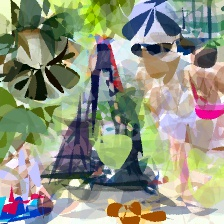

render loss: -1.22265625
iteration: 350

Top predictions:

          summer: 52.10%
          france: 12.77%
        vacation: 2.94%
          french: 2.64%
        umbrella: 2.22%
Scene construction, time: 0.00211 s
Forward pass, time: 0.07000 s
Backward pass, time: 0.19214 s
Scene construction, time: 0.00136 s
Forward pass, time: 0.07120 s
Backward pass, time: 0.19288 s
Scene construction, time: 0.00155 s
Forward pass, time: 0.07184 s
Backward pass, time: 0.19045 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.07246 s
Backward pass, time: 0.19338 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.07097 s
Backward pass, time: 0.19049 s
Scene construction, time: 0.00155 s
Forward pass, time: 0.07141 s
Backward pass, time: 0.18951 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.07085 s
Backward pass, time: 0.19301 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.07128 s
Backward pass, time: 0.19299 s
Scene construction, time: 0.00141 s
Forward

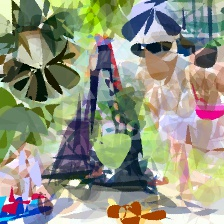

render loss: -1.1708984375
iteration: 360

Top predictions:

          summer: 69.92%
          france: 14.65%
          french: 3.17%
        vacation: 1.89%
            july: 0.73%
Scene construction, time: 0.00207 s
Forward pass, time: 0.06890 s
Backward pass, time: 0.19045 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.07072 s
Backward pass, time: 0.19331 s
Scene construction, time: 0.00136 s
Forward pass, time: 0.07052 s
Backward pass, time: 0.19030 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.07131 s
Backward pass, time: 0.19162 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.07147 s
Backward pass, time: 0.19178 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.07109 s
Backward pass, time: 0.19285 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.07103 s
Backward pass, time: 0.19180 s
Scene construction, time: 0.00159 s
Forward pass, time: 0.07311 s
Backward pass, time: 0.19751 s
Scene construction, time: 0.00140 s
Forwa

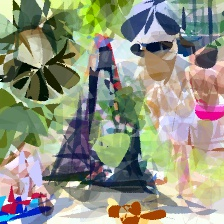

render loss: -1.19921875
iteration: 370

Top predictions:

          summer: 85.25%
        vacation: 5.71%
          france: 3.46%
            july: 0.84%
          french: 0.61%
Scene construction, time: 0.00201 s
Forward pass, time: 0.07069 s
Backward pass, time: 0.19435 s
Scene construction, time: 0.00143 s
Forward pass, time: 0.07334 s
Backward pass, time: 0.19268 s
Scene construction, time: 0.00154 s
Forward pass, time: 0.07149 s
Backward pass, time: 0.19341 s
Scene construction, time: 0.00135 s
Forward pass, time: 0.07152 s
Backward pass, time: 0.19460 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.07299 s
Backward pass, time: 0.19442 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.07251 s
Backward pass, time: 0.19445 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.07132 s
Backward pass, time: 0.19364 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.07318 s
Backward pass, time: 0.19262 s
Scene construction, time: 0.00145 s
Forward 

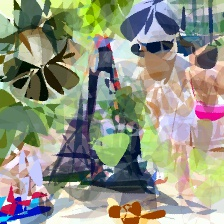

render loss: -1.2109375
iteration: 380

Top predictions:

          summer: 79.10%
          france: 4.26%
          french: 1.75%
            july: 1.43%
        vacation: 1.08%
Scene construction, time: 0.00227 s
Forward pass, time: 0.06959 s
Backward pass, time: 0.19235 s
Scene construction, time: 0.00156 s
Forward pass, time: 0.07129 s
Backward pass, time: 0.19419 s
Scene construction, time: 0.00153 s
Forward pass, time: 0.07154 s
Backward pass, time: 0.19276 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.07113 s
Backward pass, time: 0.19149 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.07115 s
Backward pass, time: 0.19354 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.07060 s
Backward pass, time: 0.19465 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.07080 s
Backward pass, time: 0.19577 s
Scene construction, time: 0.00154 s
Forward pass, time: 0.07084 s
Backward pass, time: 0.19333 s
Scene construction, time: 0.00143 s
Forward p

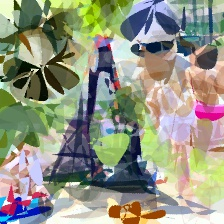

render loss: -1.1767578125
iteration: 390

Top predictions:

          summer: 80.71%
          france: 4.35%
          french: 1.96%
        vacation: 1.46%
            july: 1.39%
Scene construction, time: 0.00205 s
Forward pass, time: 0.06939 s
Backward pass, time: 0.19405 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.06967 s
Backward pass, time: 0.19220 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.07083 s
Backward pass, time: 0.19689 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.07092 s
Backward pass, time: 0.19322 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.07117 s
Backward pass, time: 0.19212 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.07256 s
Backward pass, time: 0.19372 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.07100 s
Backward pass, time: 0.19303 s
Scene construction, time: 0.00156 s
Forward pass, time: 0.07125 s
Backward pass, time: 0.19459 s
Scene construction, time: 0.00146 s
Forwar

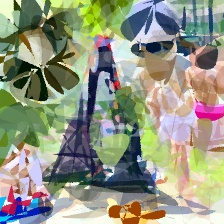

render loss: -1.1875
iteration: 400

Top predictions:

          summer: 85.21%
          france: 2.10%
            july: 1.71%
        vacation: 1.44%
         holiday: 0.74%
Scene construction, time: 0.00231 s
Forward pass, time: 0.07016 s
Backward pass, time: 0.19521 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.07114 s
Backward pass, time: 0.19205 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.07139 s
Backward pass, time: 0.19323 s
Scene construction, time: 0.00155 s
Forward pass, time: 0.07530 s
Backward pass, time: 0.19418 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.07198 s
Backward pass, time: 0.19380 s
Scene construction, time: 0.00137 s
Forward pass, time: 0.08163 s
Backward pass, time: 0.19754 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.07144 s
Backward pass, time: 0.19205 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.07123 s
Backward pass, time: 0.19267 s
Scene construction, time: 0.00147 s
Forward pass

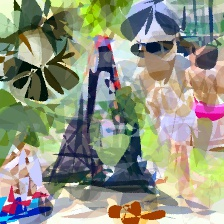

render loss: -1.2607421875
iteration: 410

Top predictions:

          summer: 92.33%
        vacation: 0.93%
          france: 0.81%
            july: 0.77%
       afternoon: 0.38%
Scene construction, time: 0.00227 s
Forward pass, time: 0.07036 s
Backward pass, time: 0.19281 s
Scene construction, time: 0.00150 s
Forward pass, time: 0.07187 s
Backward pass, time: 0.19268 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.07302 s
Backward pass, time: 0.19337 s
Scene construction, time: 0.00143 s
Forward pass, time: 0.07323 s
Backward pass, time: 0.19565 s
Scene construction, time: 0.00139 s
Forward pass, time: 0.07390 s
Backward pass, time: 0.19216 s
Scene construction, time: 0.00162 s
Forward pass, time: 0.07186 s
Backward pass, time: 0.20054 s
Scene construction, time: 0.00143 s
Forward pass, time: 0.07212 s
Backward pass, time: 0.19206 s
Scene construction, time: 0.00139 s
Forward pass, time: 0.07222 s
Backward pass, time: 0.19408 s
Scene construction, time: 0.00153 s
Forwar

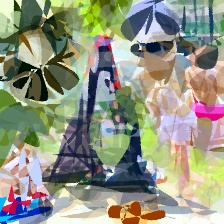

render loss: -1.2138671875
iteration: 420

Top predictions:

          summer: 89.45%
        vacation: 1.22%
            july: 0.92%
          france: 0.85%
         holiday: 0.79%
Scene construction, time: 0.00221 s
Forward pass, time: 0.07054 s
Backward pass, time: 0.19271 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.07178 s
Backward pass, time: 0.19387 s
Scene construction, time: 0.00143 s
Forward pass, time: 0.07204 s
Backward pass, time: 0.19478 s
Scene construction, time: 0.00158 s
Forward pass, time: 0.07222 s
Backward pass, time: 0.19664 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.07181 s
Backward pass, time: 0.19396 s
Scene construction, time: 0.00153 s
Forward pass, time: 0.07265 s
Backward pass, time: 0.19610 s
Scene construction, time: 0.00157 s
Forward pass, time: 0.07219 s
Backward pass, time: 0.19393 s
Scene construction, time: 0.00140 s
Forward pass, time: 0.07220 s
Backward pass, time: 0.19429 s
Scene construction, time: 0.00155 s
Forwar

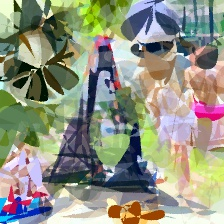

render loss: -1.3017578125
iteration: 430

Top predictions:

          summer: 79.83%
        vacation: 5.44%
          france: 2.34%
            july: 1.33%
       afternoon: 0.96%
Scene construction, time: 0.00207 s
Forward pass, time: 0.07088 s
Backward pass, time: 0.19393 s
Scene construction, time: 0.00155 s
Forward pass, time: 0.07228 s
Backward pass, time: 0.19404 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.07214 s
Backward pass, time: 0.19608 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.07234 s
Backward pass, time: 0.19310 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.07230 s
Backward pass, time: 0.19311 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.07240 s
Backward pass, time: 0.19411 s
Scene construction, time: 0.00153 s
Forward pass, time: 0.07201 s
Backward pass, time: 0.19182 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.07258 s
Backward pass, time: 0.19309 s
Scene construction, time: 0.00148 s
Forwar

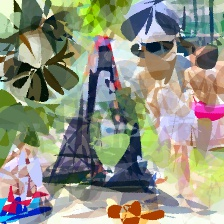

render loss: -1.271484375
iteration: 440

Top predictions:

          summer: 85.11%
        vacation: 2.49%
          france: 2.13%
            july: 0.90%
            park: 0.86%
Scene construction, time: 0.00268 s
Forward pass, time: 0.07178 s
Backward pass, time: 0.19469 s
Scene construction, time: 0.00150 s
Forward pass, time: 0.07204 s
Backward pass, time: 0.19483 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.07249 s
Backward pass, time: 0.19490 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.07615 s
Backward pass, time: 0.19446 s
Scene construction, time: 0.00149 s
Forward pass, time: 0.07229 s
Backward pass, time: 0.19595 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.07185 s
Backward pass, time: 0.19452 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.07205 s
Backward pass, time: 0.19621 s
Scene construction, time: 0.00205 s
Forward pass, time: 0.07194 s
Backward pass, time: 0.19458 s
Scene construction, time: 0.00150 s
Forward

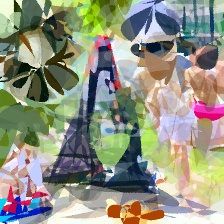

render loss: -1.23828125
iteration: 450

Top predictions:

          summer: 41.89%
        vacation: 9.34%
          france: 8.38%
            park: 6.23%
      playground: 2.19%
Scene construction, time: 0.00205 s
Forward pass, time: 0.07035 s
Backward pass, time: 0.19457 s
Scene construction, time: 0.00152 s
Forward pass, time: 0.07150 s
Backward pass, time: 0.19266 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.07354 s
Backward pass, time: 0.19229 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.07155 s
Backward pass, time: 0.19382 s
Scene construction, time: 0.00142 s
Forward pass, time: 0.07144 s
Backward pass, time: 0.19081 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.07180 s
Backward pass, time: 0.19379 s
Scene construction, time: 0.00138 s
Forward pass, time: 0.07169 s
Backward pass, time: 0.19290 s
Scene construction, time: 0.00199 s
Forward pass, time: 0.07225 s
Backward pass, time: 0.19290 s
Scene construction, time: 0.00160 s
Forward 

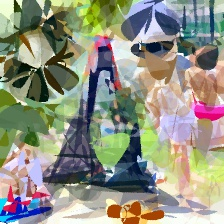

render loss: -1.2763671875
iteration: 460

Top predictions:

          summer: 78.37%
          france: 3.84%
          french: 1.68%
        vacation: 1.55%
         holiday: 0.75%
Scene construction, time: 0.00207 s
Forward pass, time: 0.07032 s
Backward pass, time: 0.19424 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.07887 s
Backward pass, time: 0.19453 s
Scene construction, time: 0.00145 s
Forward pass, time: 0.07304 s
Backward pass, time: 0.19310 s
Scene construction, time: 0.00150 s
Forward pass, time: 0.07209 s
Backward pass, time: 0.19461 s
Scene construction, time: 0.00141 s
Forward pass, time: 0.07143 s
Backward pass, time: 0.19506 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.07158 s
Backward pass, time: 0.19342 s
Scene construction, time: 0.00137 s
Forward pass, time: 0.07197 s
Backward pass, time: 0.19396 s
Scene construction, time: 0.00143 s
Forward pass, time: 0.07170 s
Backward pass, time: 0.19535 s
Scene construction, time: 0.00138 s
Forwar

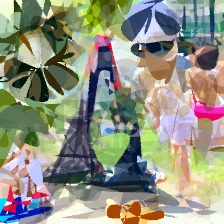

render loss: -1.2490234375
iteration: 470

Top predictions:

          summer: 95.56%
        vacation: 0.78%
          france: 0.61%
            july: 0.43%
       afternoon: 0.26%
Scene construction, time: 0.00199 s
Forward pass, time: 0.07093 s
Backward pass, time: 0.19243 s
Scene construction, time: 0.00147 s
Forward pass, time: 0.07253 s
Backward pass, time: 0.19293 s
Scene construction, time: 0.00146 s
Forward pass, time: 0.07231 s
Backward pass, time: 0.19419 s
Scene construction, time: 0.00143 s
Forward pass, time: 0.07235 s
Backward pass, time: 0.19350 s
Scene construction, time: 0.00137 s
Forward pass, time: 0.07245 s
Backward pass, time: 0.19143 s
Scene construction, time: 0.00156 s
Forward pass, time: 0.07572 s
Backward pass, time: 0.19251 s
Scene construction, time: 0.00157 s
Forward pass, time: 0.07248 s
Backward pass, time: 0.19288 s
Scene construction, time: 0.00138 s
Forward pass, time: 0.07304 s
Backward pass, time: 0.19411 s
Scene construction, time: 0.00145 s
Forwar

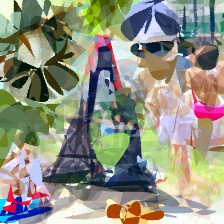

render loss: -1.2529296875
iteration: 480

Top predictions:

          summer: 64.60%
        vacation: 5.06%
          france: 5.06%
            park: 1.98%
          avenue: 1.32%
Scene construction, time: 0.00204 s
Forward pass, time: 0.07076 s
Backward pass, time: 0.19266 s
Scene construction, time: 0.00579 s
Forward pass, time: 0.07311 s
Backward pass, time: 0.19333 s
Scene construction, time: 0.00139 s
Forward pass, time: 0.07339 s
Backward pass, time: 0.19273 s
Scene construction, time: 0.00153 s
Forward pass, time: 0.07285 s
Backward pass, time: 0.19159 s
Scene construction, time: 0.00143 s
Forward pass, time: 0.07335 s
Backward pass, time: 0.19496 s
Scene construction, time: 0.00148 s
Forward pass, time: 0.07268 s
Backward pass, time: 0.19379 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.07391 s
Backward pass, time: 0.19379 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.07308 s
Backward pass, time: 0.19350 s
Scene construction, time: 0.00190 s
Forwar

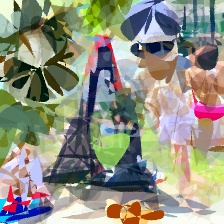

render loss: -1.287109375
iteration: 490

Top predictions:

          summer: 91.06%
          france: 2.93%
        vacation: 0.97%
          french: 0.91%
            july: 0.49%
Scene construction, time: 0.00215 s
Forward pass, time: 0.07178 s
Backward pass, time: 0.19613 s
Scene construction, time: 0.00144 s
Forward pass, time: 0.07275 s
Backward pass, time: 0.19537 s
Scene construction, time: 0.00159 s
Forward pass, time: 0.07310 s
Backward pass, time: 0.19539 s
Scene construction, time: 0.00150 s
Forward pass, time: 0.07300 s
Backward pass, time: 0.19306 s
Scene construction, time: 0.00153 s
Forward pass, time: 0.07345 s
Backward pass, time: 0.19496 s
Scene construction, time: 0.00151 s
Forward pass, time: 0.07368 s
Backward pass, time: 0.19771 s
Scene construction, time: 0.00156 s
Forward pass, time: 0.07317 s
Backward pass, time: 0.19457 s
Scene construction, time: 0.00153 s
Forward pass, time: 0.07344 s
Backward pass, time: 0.19479 s
Scene construction, time: 0.00144 s
Forward

In [ ]:
#@title Train{vertical-output: true}
# import diffvg
%cd /{RELATIVE_PATH}/diffvg/apps/
import pydiffvg
import torch
import skimage
import skimage.io
import random
import ttools.modules
import argparse
import math
import torchvision
import torchvision.transforms as transforms


neg_prompt = "A badly drawn sketch."
neg_prompt_2 = "Many ugly, messy drawings."

text_input = clip.tokenize(prompt).to(device)
text_input_neg1 = clip.tokenize(neg_prompt).to(device)
text_input_neg2 = clip.tokenize(neg_prompt_2).to(device)
# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_input)
    text_features_neg1 = model.encode_text(text_input_neg1)
    text_features_neg2 = model.encode_text(text_input_neg2)


pydiffvg.set_print_timing(False)

gamma = 1.0

# Use GPU if available
pydiffvg.set_use_gpu(torch.cuda.is_available())
device = torch.device('cuda')
pydiffvg.set_device(device)

canvas_width, canvas_height = 224, 224
num_paths = args.num_paths
max_width = args.max_width

# Image Augmentation Transformation
augment_trans = transforms.Compose([
    transforms.RandomPerspective(fill=1, p=1, distortion_scale=0.5),
    transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
])

if use_normalized_clip:
    augment_trans = transforms.Compose([
    transforms.RandomPerspective(fill=1, p=1, distortion_scale=0.5),
    transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])


if random_init:
  # Initialize Random Curves
  shapes = []
  shape_groups = []
  for i in range(num_paths):
      num_segments = random.randint(1, 3)
      num_control_points = torch.zeros(num_segments, dtype = torch.int32) + 2
      points = []
      p0 = (random.random(), random.random())
      points.append(p0)
      for j in range(num_segments):
          radius = 0.1
          p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
          p2 = (p1[0] + radius * (random.random() - 0.5), p1[1] + radius * (random.random() - 0.5))
          p3 = (p2[0] + radius * (random.random() - 0.5), p2[1] + radius * (random.random() - 0.5))
          points.append(p1)
          points.append(p2)
          points.append(p3)
          p0 = p3
      points = torch.tensor(points)
      points[:, 0] *= canvas_width
      points[:, 1] *= canvas_height
      path = pydiffvg.Path(num_control_points = num_control_points, points = points, stroke_width = torch.tensor(1.0), is_closed = False)
      shapes.append(path)
      path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]), fill_color = None, stroke_color = torch.tensor([random.random(), random.random(), random.random(), random.random()]))                            
      shape_groups.append(path_group)

  # Just some diffvg setup
  scene_args = pydiffvg.RenderFunction.serialize_scene(\
      canvas_width, canvas_height, shapes, shape_groups)
  render = pydiffvg.RenderFunction.apply
  img = render(canvas_width, canvas_height, 2, 2, 0, None, *scene_args)
else:
  render = pydiffvg.RenderFunction.apply
  img,shapes,shape_groups = image_render.render_img(img_init_path,
                                       result_folder,
                                       num_paths=num_paths,
                                       max_width=max_width,
                                       use_lpips_loss=use_lpips_loss,
                                       use_blob=use_blob,
                                       num_iter=num_iter_render,)



points_vars = []
stroke_width_vars = []
color_vars = []
for path in shapes:
    path.points.requires_grad = True
    points_vars.append(path.points)
    path.stroke_width.requires_grad = True
    stroke_width_vars.append(path.stroke_width)
for group in shape_groups:
    if use_blob:
      group.fill_color.requires_grad = True
      color_vars.append(group.fill_color)
    else:
      group.stroke_color.requires_grad = True
      color_vars.append(group.stroke_color)

# Optimizers
points_optim = torch.optim.Adam(points_vars, lr=1.0)
width_optim = torch.optim.Adam(stroke_width_vars, lr=0.1)
color_optim = torch.optim.Adam(color_vars, lr=0.01)

# Run the main optimization loop
for t in range(args.num_iter):

    # Anneal learning rate (makes videos look cleaner)
    if t == int(args.num_iter * 0.5):
        for g in points_optim.param_groups:
            g['lr'] = 0.4
    if t == int(args.num_iter * 0.75):
        for g in points_optim.param_groups:
            g['lr'] = 0.1
    
    points_optim.zero_grad()
    width_optim.zero_grad()
    color_optim.zero_grad()
    scene_args = pydiffvg.RenderFunction.serialize_scene(canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, canvas_height, 2, 2, t, None, *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
    if t % 5 == 0:
        pydiffvg.imwrite(img.cpu(), '/{}/res/{}/iter_{}.png'.format(RELATIVE_PATH,result_folder,int(t/5)), gamma=gamma)
    img = img[:, :, :3]
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW

    loss = 0
    NUM_AUGS = 4
    img_augs = []
    for n in range(NUM_AUGS):
        img_augs.append(augment_trans(img))
    im_batch = torch.cat(img_augs)
    image_features = model.encode_image(im_batch)
    for n in range(NUM_AUGS):
        loss -= torch.cosine_similarity(text_features, image_features[n:n+1], dim=1)
        if use_negative:
            loss += torch.cosine_similarity(text_features_neg1, image_features[n:n+1], dim=1) * 0.3
            loss += torch.cosine_similarity(text_features_neg2, image_features[n:n+1], dim=1) * 0.3

    # Backpropagate the gradients.
    loss.backward()

    # Take a gradient descent step.
    points_optim.step()
    width_optim.step()
    color_optim.step()
    for path in shapes:
        path.stroke_width.data.clamp_(1.0, max_width)
    for group in shape_groups:
      if use_blob:
        group.fill_color.data.clamp_(0.0, 1.0)
      else:
        group.stroke_color.data.clamp_(0.0, 1.0)
    
    if t % 10 == 0:
        utils.show_img(img.detach().cpu().numpy()[0])
        print('render loss:', loss.item())
        print('iteration:', t)
        with torch.no_grad():
            im_norm = image_features / image_features.norm(dim=-1, keepdim=True)
            noun_norm = nouns_features / nouns_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * im_norm @ noun_norm.T).softmax(dim=-1)
            values, indices = similarity[0].topk(5)
            print("\nTop predictions:\n")
            for value, index in zip(values, indices):
                print(f"{nouns[index]:>16s}: {100 * value.item():.2f}%")

# Results

In [ ]:
# images paths
img_origin = img_init_path
img_render_start = f'{RELATIVE_PATH}/diffvg/apps/results/painterly_rendering/{result_folder}/iter_{0}.png'
img_render_end = f'{RELATIVE_PATH}/diffvg/apps/results/painterly_rendering/{result_folder}/iter_{num_iter_render-1}.png'
img_init_random = f'{RELATIVE_PATH}/res/{result_folder}/iter_0.png'
img_result = f'{RELATIVE_PATH}/res/{result_folder}/iter_{int(args.num_iter/5-1)}.png'

images_path_pre_learn = [img_origin,img_render_start,img_render_end]
images_text_pre_learn = ['Origin image','Init Vector','Vector image']
images_path_main_learn = [img_render_end,img_result]
images_text_main_learn = ['Vector image','Result']
images_path_main_learn_random_init = [img_init_random,img_result]
images_text_main_learn_random_init = ['Init random','Result']

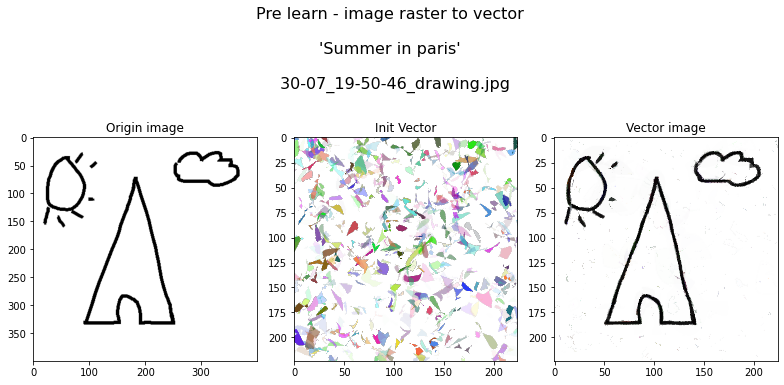

In [ ]:
# display images
if random_init:
  print("No results in random_init mode")
else:
  fig, ax = plt.subplots(1,len(images_path_pre_learn))
  fig.suptitle(f"Pre learn - image raster to vector \n\n'{prompt}' \n\n {img_init_path.split('/')[-1]}", fontsize=16)
  for i in range(len(images_path_pre_learn)):
    # read image
    img = mpimg.imread(images_path_pre_learn[i])
    # plot image
    ax[i].imshow(img)
    ax[i].title.set_text(images_text_pre_learn[i])
  fig.tight_layout()
  fig.subplots_adjust(top=1.1)
  plt.savefig(f'{RELATIVE_PATH}/res/{result_folder}/_pre_learn.png')
  plt.show()

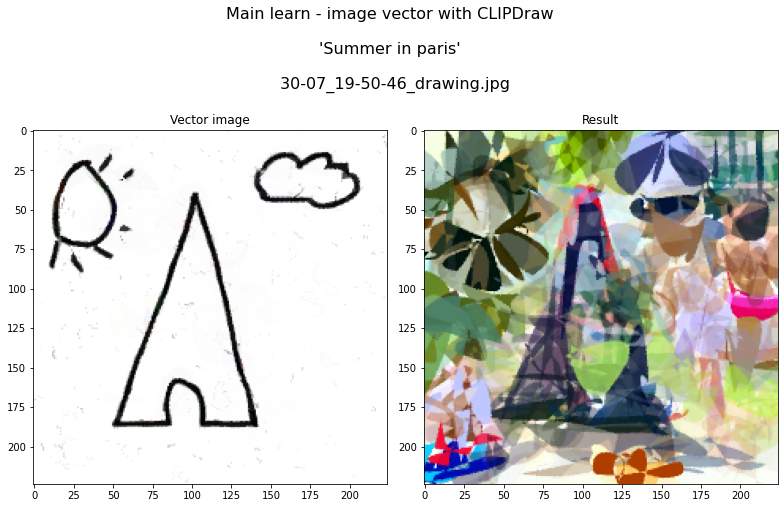

In [ ]:
# display images
fig, ax = plt.subplots(1,len(images_path_main_learn))
fig.suptitle(f"Main learn - image vector with CLIPDraw \n\n'{prompt}' \n\n {img_init_path.split('/')[-1]}", fontsize=16)
if random_init:
  for i in range(len(images_path_main_learn_random_init)):
    # read image
    img = mpimg.imread(images_path_main_learn_random_init[i])
    # plot image
    ax[i].imshow(img)
    ax[i].title.set_text(images_text_main_learn_random_init[i])
else:
  for i in range(len(images_path_main_learn)):
    # read image
    img = mpimg.imread(images_path_main_learn[i])
    # plot image
    ax[i].imshow(img)
    ax[i].title.set_text(images_text_main_learn[i])
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig(f'{RELATIVE_PATH}/res/{result_folder}/_main_learn.png')
plt.show()

In [ ]:
#@title Video Renderer {vertical-output: true}
%cd /{RELATIVE_PATH}
pydiffvg.set_print_timing(False)
# Render a picture with each stroke.
with torch.no_grad():
    for i in range(args.num_paths):
        scene_args = pydiffvg.RenderFunction.serialize_scene(\
            canvas_width, canvas_height, shapes[:i+1], shape_groups[:i+1])
        img = render(canvas_width, canvas_height, 2, 2, t, None, *scene_args)
        img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        pydiffvg.imwrite(img.cpu(), '/res/{}/stroke_{}.png'.format(result_folder,i), gamma=gamma)

  skimage.io.imsave(filename, (img * 255).astype(np.uint8))



/content/draw-clipdraw


In [ ]:
print("ffmpeging")
# Convert the intermediate renderings to a video.
from subprocess import call
r = call(["ffmpeg", "-y", "-framerate", "60", "-i",
    f"./res/{result_folder}/iter_%d.png", "-vb", "10M",
    f"/{RELATIVE_PATH}/res/{result_folder}/out.mp4"])
print(r)

r = call(["ffmpeg", "-y", "-framerate", "60", "-i",
    f"/res/{result_folder}/stroke_%d.png", "-vb", "20M",
    f"/{RELATIVE_PATH}/res/{result_folder}/out_strokes.mp4"])
print(r)


ffmpeging
0
0


In [ ]:
display(utils.mvp.ipython_display(f"{RELATIVE_PATH}/res/{result_folder}/out.mp4"))
display(utils.mvp.ipython_display(f"{RELATIVE_PATH}/res/{result_folder}/out_strokes.mp4"))